## Курсовой проект

#### Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [5]:
# Загрузка данных

train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

#### Оптимизация использования памяти

In [6]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [8]:
train_df['Rooms'] = train_df['Rooms'].astype(np.int64)
train_df['HouseFloor'] = train_df['HouseFloor'].astype(np.int64)
test_df['Rooms'] = test_df['Rooms'].astype(np.int64)
test_df['HouseFloor'] = test_df['HouseFloor'].astype(np.int64)

In [9]:
reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.43 MB
Decreased by 71.8%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3,115.027313,NaN,10.0,4,10,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,3013,22,1,39.832523,23.169222,8.0,7,8,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,8215,1,3,78.342216,47.671970,10.0,2,17,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750
3,2352,1,1,40.409908,NaN,1.0,10,22,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
4,13866,94,2,64.285065,38.562515,9.0,16,16,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.093750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2,49.090729,33.272625,6.0,3,12,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.453125
9996,16265,27,2,64.307686,37.038422,9.0,13,0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.156250
9997,2795,178,1,29.648056,16.555363,5.0,3,5,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.906250
9998,14561,21,1,32.330292,22.326870,5.0,3,9,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.406250


In [10]:
reduce_mem_usage(test_df)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.19 MB
Decreased by 74.3%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1,36.847630,19.094183,5.0,5,9,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1,42.493908,42.568134,10.0,7,17,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2,59.463676,NaN,9.0,19,19,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3,49.646030,33.893826,6.0,2,2,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1,53.837055,NaN,1.0,8,17,1977,0.309479,B,B,35,7715,4,990.0,0,6,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,29,2,43.177521,30.339945,5.0,6,5,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3,93.698120,94.521461,10.0,21,27,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1,33.656723,19.003260,5.0,2,5,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1,38.635155,20.976257,9.0,8,14,1970,0.089040,B,B,33,7976,5,NaN,0,11,B


#### Анализ данных

In [11]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,8383.407700,4859.019020,0.000000,4169.500000,8394.500000,12592.500000,1.679800e+04
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315777,21.058731,1.136859,41.774879,52.513309,65.900627,6.410652e+02
LifeSquare,7887.0,37.199646,86.241211,0.370619,22.769833,32.781261,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218670e-01


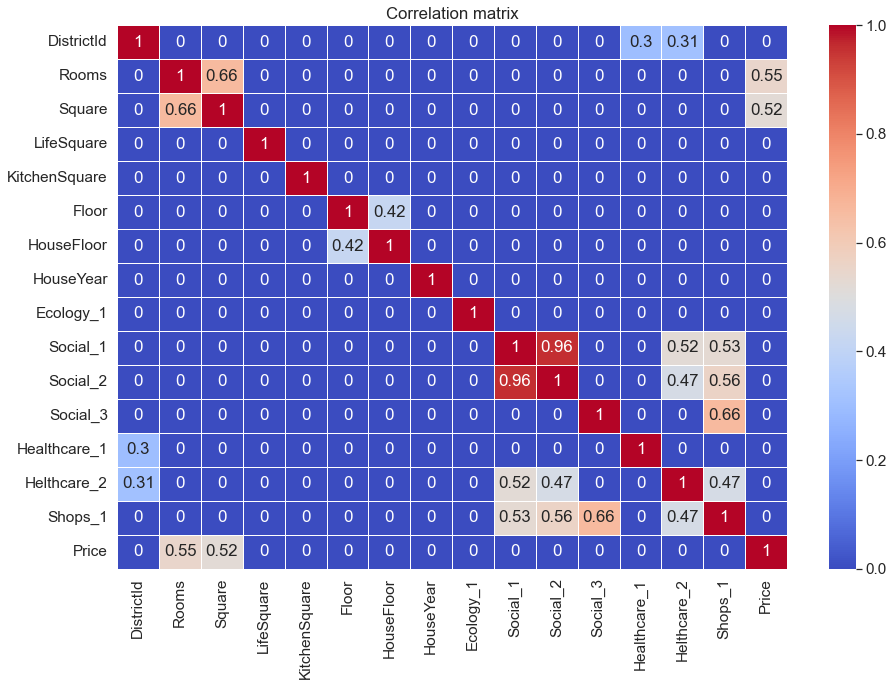

In [12]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = train_df.drop('Id', axis=1).corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

#### Предварительная обработка

In [13]:
# Рассчитаваем статистики

medians = train_df[['Rooms', 'HouseFloor', 'Square', 'LifeSquare', 'KitchenSquare', 'HouseYear', 
                        'Ecology_1', 'Healthcare_1', 'Social_2']].median()
medians

Rooms               2.000000
HouseFloor         13.000000
Square             52.513309
LifeSquare         32.781261
KitchenSquare       6.000000
HouseYear        1977.000000
Ecology_1           0.075424
Healthcare_1      900.000000
Social_2         5285.000000
dtype: float64

In [14]:
# Заполняем пропуски

train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = medians['LifeSquare']
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = medians['Healthcare_1']

In [15]:
# Обрабатываем некорректные значения

train_df.loc[(train_df['Rooms'] > 6) | (train_df['Rooms'] == 0), 'Rooms'] = medians['Rooms']
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor'] = train_df['Floor']

life_square_coeff = medians['Square'] / medians['LifeSquare']
train_df.loc[train_df['LifeSquare'] > train_df['Square'], 'LifeSquare'] = train_df['Square'] / life_square_coeff

kitchen_square_coeff = medians['Square'] / medians['KitchenSquare']
train_df.loc[train_df['KitchenSquare'] > train_df['Square'], 'KitchenSquare'] = train_df['Square'] / kitchen_square_coeff


In [16]:
# Устраняем выбросы

train_df.loc[train_df['HouseYear'] > 2020,'HouseYear'] = medians['HouseYear']

train_df.loc[(train_df['Ecology_1'] > train_df['Ecology_1'].quantile(.975)) |
                        (train_df['Ecology_1'] < train_df['Ecology_1'].quantile(.025)), 'Ecology_1'] = medians['Ecology_1']

train_df.loc[(train_df['Social_2'] > train_df['Social_2'].quantile(.975)) |
                        (train_df['Social_2'] < train_df['Social_2'].quantile(.025)), 'Social_2'] = medians['Social_2']


In [17]:
# Преобразование номинативных переменных в количественные

train_df = pd.concat([train_df, pd.get_dummies(train_df[['Ecology_2', 'Ecology_3', 'Shops_2']], 
                                               prefix=['Ecology_2', 'Ecology_3', 'Shops_2'])], axis=1)

#### Построение модели

In [18]:
# Формирование фичей и таргета
x = train_df.drop(['Id', 'Price', 'Social_1', 'Ecology_2', 'Ecology_3', 'Shops_2'], axis=1)
y = train_df['Price']

# Стандиртизация
scaler = MinMaxScaler()
stand_features = scaler.fit_transform(x)
x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)

# Разделение на обучающую и тестовые выборки
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 21)

In [19]:
forest = RandomForestRegressor(n_jobs=-1)
forest.fit(x_train, y_train)

RandomForestRegressor(n_jobs=-1)

Train R2:	0.96
Test R2:	0.746


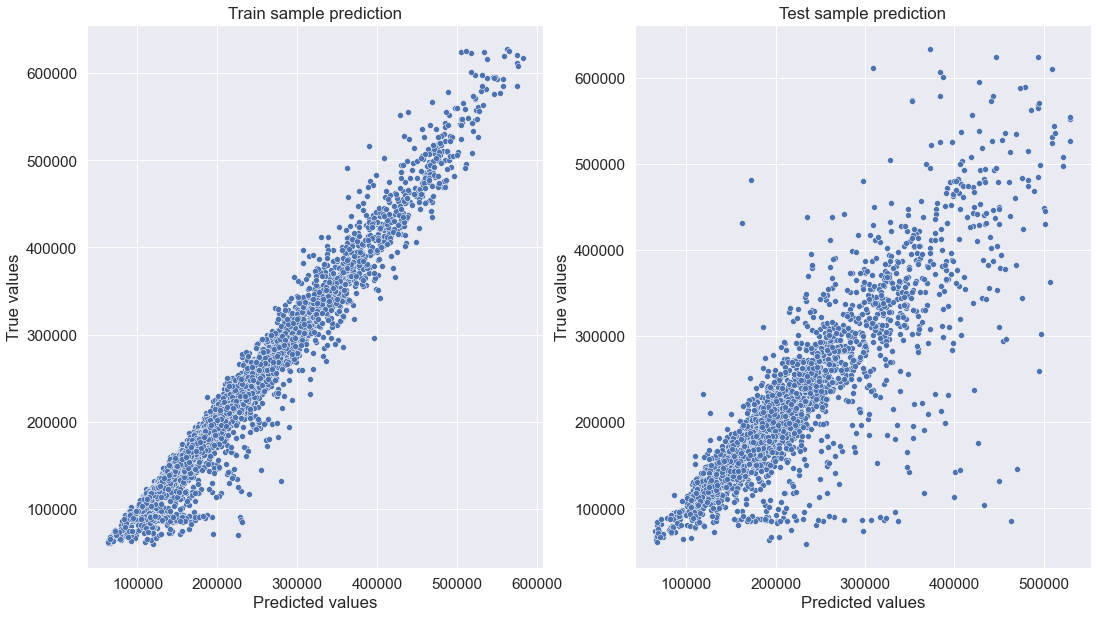

In [20]:
# Анализ качества моделирования

train_pred = forest.predict(x_train)
test_pred = forest.predict(x_test)
evaluate_preds(y_train, train_pred, y_test, test_pred)

#### Обработка тестовых данных

In [21]:
# Заполняем пропуски

test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare'] = medians['LifeSquare']
test_df.loc[test_df['Healthcare_1'].isnull(), 'Healthcare_1'] = medians['Healthcare_1']

In [22]:
# Обрабатываем некорректные значения

test_df.loc[(test_df['Rooms'] > 6) | (test_df['Rooms'] == 0), 'Rooms'] = medians['Rooms']
test_df.loc[test_df['Floor'] > test_df['HouseFloor'], 'HouseFloor'] = test_df['Floor']
test_df.loc[test_df['LifeSquare'] > test_df['Square'], 'LifeSquare'] = test_df['Square'] / life_square_coeff
test_df.loc[test_df['KitchenSquare'] > test_df['Square'], 'KitchenSquare'] = test_df['Square'] / kitchen_square_coeff

In [23]:
# Устраняем выбросы

test_df.loc[test_df['HouseYear'] > 2020,'HouseYear'] = medians['HouseYear']

test_df.loc[(test_df['Ecology_1'] > test_df['Ecology_1'].quantile(.975)) |
                        (test_df['Ecology_1'] < test_df['Ecology_1'].quantile(.025)), 'Ecology_1'] = medians['Ecology_1']

test_df.loc[(test_df['Social_2'] > test_df['Social_2'].quantile(.975)) |
                        (test_df['Social_2'] < test_df['Social_2'].quantile(.025)), 'Social_2'] = medians['Social_2']


In [24]:
# Преобразование номинативных переменных в количественные

test_df = pd.concat([test_df, pd.get_dummies(test_df[['Ecology_2', 'Ecology_3', 'Shops_2']], 
                                               prefix=['Ecology_2', 'Ecology_3', 'Shops_2'])], axis=1)

#### Построение прогноза на тестовых данных

In [25]:
# Формирование фичей
x = test_df.drop(['Id', 'Social_1', 'Ecology_2', 'Ecology_3', 'Shops_2'], axis=1)

# Стандиртизация
scaler = MinMaxScaler()
stand_features = scaler.fit_transform(x)
x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)

# Расчет прогнозной цены
price = forest.predict(x)

In [26]:
test_df.drop(['Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B'], axis=1, inplace=True)
test_df['price_pred'] = price
test_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,price_pred
0,4567,44,1,36.847630,19.094183,5.0,5,9,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B,376733.656016
1,5925,62,1,42.493908,26.526682,10.0,7,17,2017,0.072158,B,B,2,629,1,900.0,0,0,A,266119.298906
2,960,27,2,59.463676,32.781261,9.0,19,19,1977,0.211401,B,B,9,1892,0,900.0,0,1,B,298846.980156
3,3848,23,3,49.646030,33.893826,6.0,2,2,1965,0.014073,B,B,2,475,0,900.0,0,0,B,273151.326406
4,746,74,1,53.837055,32.781261,1.0,8,17,1977,0.309479,B,B,35,7715,4,990.0,0,6,B,364973.190078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,29,2,43.177521,30.339945,5.0,6,6,1962,0.069660,B,B,31,6119,4,900.0,1,2,B,434338.496641
4996,16138,38,3,93.698120,58.490746,10.0,21,27,2018,0.060753,B,B,15,2787,2,520.0,0,7,B,333328.091562
4997,3912,101,1,33.656723,19.003260,5.0,2,5,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B,323950.605234
4998,5722,10,1,38.635155,20.976257,9.0,8,14,1970,0.089040,B,B,33,7976,5,900.0,0,11,B,445271.881406


In [27]:
test_df.to_csv('AZacepin_predictions.csv', index=False)